In [1]:
%%capture
!pip install diffusers==0.21.4
!pip install invisible_watermark transformers accelerate safetensors

# Text-to-image generation with DeciDiffusion and HuggingFace 🧨diffusers

Check out [the Space](https://huggingface.co/spaces/Deci/DeciDiffusion-v2-0) on HuggingFace and [the technical blog](https://deci.ai/blog/decidiffusion-2-0-text-to-image-generation-optimized-for-cost-effective-hardware/) for more information.

This notebook will demonstrate generations with DeciDiffusion and show how quick it is to generate images.

The end of the notebook will also have generations and timings of the same prompts for StableDiffusion 1.5

**Note:** All generation times shown below are from a single T4 GPU

In [2]:
import torch
import os
import time
from IPython.core.display import display, HTML

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from diffusers import StableDiffusionPipeline

import os
import torch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import time

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# 1️⃣ Step 1: Load custom pipeline from DeciDiffusion repo

In [ ]:
pipeline = 'Deci/DeciDiffusion-v2-0'
deci_diffusion_pipeline = StableDiffusionPipeline.from_pretrained(pipeline,
                                                   custom_pipeline=pipeline,
                                                   torch_dtype=torch.float16
                                                   )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/621 [00:00<?, ?B/s]

pipeline.py:   0%|          | 0.00/44.6k [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/510 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/669 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.70k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.05G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.94k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

# 2️⃣ Step 2:  Load custom unet from DeciDiffusion repo, set it to `pipeline` object's UNet

In [ ]:
deci_diffusion_pipeline.unet = deci_diffusion_pipeline.unet.from_pretrained(pipeline,
                                              subfolder='flexible_unet',
                                              torch_dtype=torch.float16)

# Move pipeline to device
deci_diffusion_pipeline = deci_diffusion_pipeline.to('cuda')

flexible_unet/config.json:   0%|          | 0.00/2.77k [00:00<?, ?B/s]

The config attributes {'act_fn': 'silu', 'addition_embed_type': None, 'addition_embed_type_num_heads': 64, 'addition_time_embed_dim': None, 'attention_head_dim': 8, 'attention_type': 'default', 'block_out_channels': [320, 640, 1280, 1280], 'center_input_sample': False, 'class_embed_type': None, 'class_embeddings_concat': False, 'configurations': {'add_downsample': [True, True, False], 'add_upsample': [True, True, False], 'add_upsample_mid_block': None, 'cross_attention_dim': 768, 'down_blocks_in_channels': [320, 320, 640], 'down_blocks_num_attentions': [0, 1, 3], 'down_blocks_num_resnets': [2, 2, 1], 'down_blocks_out_channels': [320, 640, 1280], 'mid_num_attentions': 0, 'mid_num_resnets': 0, 'mix_block_in_forward': True, 'num_attention_heads': 8, 'prev_output_channels': [1280, 1280, 640], 'resnet_act_fn': 'silu', 'resnet_eps': 1e-05, 'sample_size': 64, 'temb_dim': 1280, 'up_blocks_num_attentions': [5, 3, 0], 'up_blocks_num_resnets': [2, 3, 3]}, 'conv_in_kernel': 3, 'conv_out_kernel': 3

# 3️⃣ Step 3: Generate Image

In [ ]:
def text_to_image(pipeline, prompt):

    # Start the timer
    start_time = time.time()

    # Call the pipeline function directly
    result = pipeline([prompt], generator=torch.Generator("cuda").manual_seed(42))

    # Calculate and print the elapsed time
    elapsed_time = time.time() - start_time
    display(HTML(f'<span style="color: #3264ff; font-weight:bold;font-size: 20px;">Time taken to generate: {elapsed_time:.2f} seconds</span>'))

    img = result.images[0]

    filename = prompt.replace(' ', '_')
    if len(filename) > 100:  # Limit filename to 100 characters
        filename = filename[:100]

    # Incorporate the pipeline's class name into the filename
    pipeline_name = pipeline.__class__.__name__
    save_path = os.path.join("/content", f"{pipeline_name}_{filename}.png")
    img.save(save_path)

    # Display the saved image
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return save_path

For reference, [here](https://cdn.britannica.com/13/173813-050-1DCA15F5/Harmandir-Sahib-Amritsar-India-Punjab.jpg) is a picture of the actual Golden Temple.

  0%|          | 0/10 [00:00<?, ?it/s]

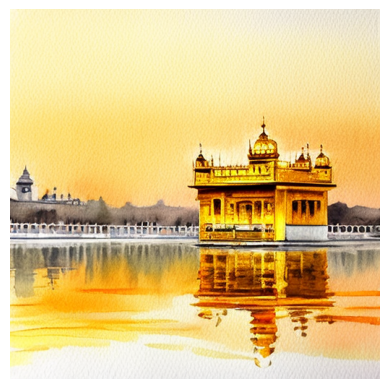

'/content/DeciDiffusionPipeline_a_water_color_painting_of_the_Golden_Temple_awash_in_the_glow_of_morning_light_with_a_vanilla_sky.png'

In [ ]:
text_to_image(deci_diffusion_pipeline, "a water color painting of the Golden Temple awash in the glow of morning light with a vanilla sky")

  0%|          | 0/10 [00:00<?, ?it/s]

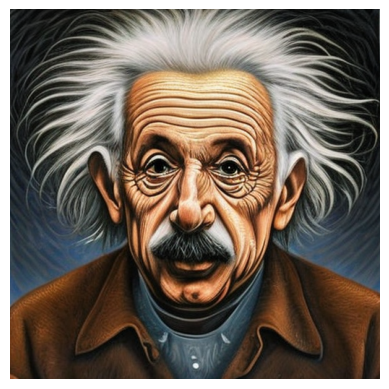

'/content/DeciDiffusionPipeline_a_realistic_portrait_of_albert_einstein_with_a_bewildered_expression.png'

In [ ]:
text_to_image(deci_diffusion_pipeline, "a realistic portrait of albert einstein with a bewildered expression")

  0%|          | 0/10 [00:00<?, ?it/s]

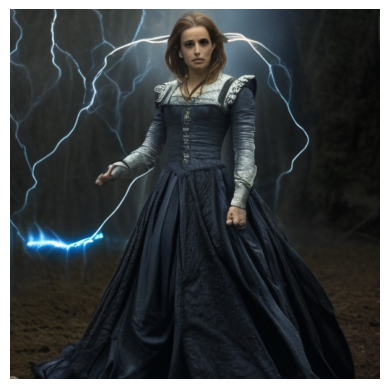

'/content/DeciDiffusionPipeline_Emma_Watson_as_a_powerful_mysterious_sorceress,_casting_lightning_magic,_detailed_clothing.png'

In [ ]:
text_to_image(deci_diffusion_pipeline, "Emma Watson as a powerful mysterious sorceress, casting lightning magic, detailed clothing")

  0%|          | 0/10 [00:00<?, ?it/s]

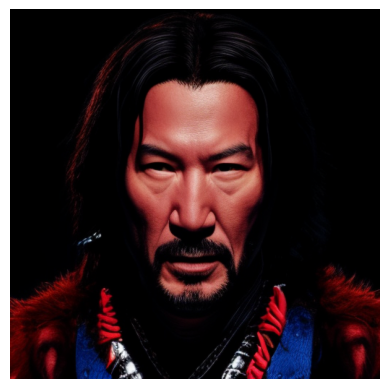

'/content/DeciDiffusionPipeline_Keanu_Reeves_portrait_photo_of_a_asia_old_warrior_chief,_tribal_panther_make_up,_blue_on_red,_side_p.png'

In [ ]:
prompt = "Keanu Reeves portrait photo of a asia old warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes, 50mm portrait photography, hard rim lighting photography–beta –ar 2:3 –beta –upbeta –beta –upbeta –beta –upbeta"

text_to_image(deci_diffusion_pipeline, prompt)

  0%|          | 0/10 [00:00<?, ?it/s]

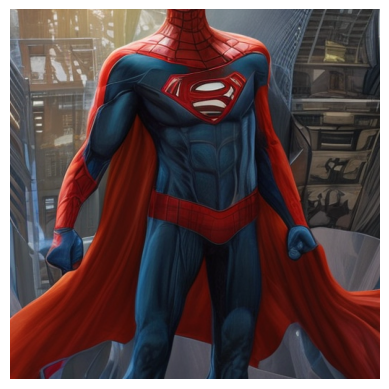

'/content/DeciDiffusionPipeline_clear_portrait_of_a_superhero_concept_between_spiderman_and_batman,_cottagecore!!,_background_hyper_.png'

In [ ]:
prompt = "clear portrait of a superhero concept between spiderman and batman, cottagecore!!, background hyper detailed, character concept, full body, dynamic pose, intricate, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha"
text_to_image(deci_diffusion_pipeline, prompt)

  0%|          | 0/10 [00:00<?, ?it/s]

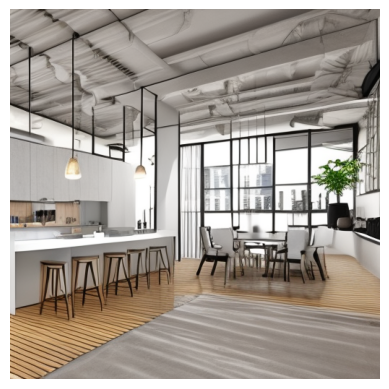

'/content/DeciDiffusionPipeline_interior_design,_open_plan,_kitchen_and_living_room,_modular_furniture_with_cotton_textiles,_wooden_.png'

In [ ]:
prompt = "interior design, open plan, kitchen and living room, modular furniture with cotton textiles, wooden floor, high ceiling, large steel windows viewing a city"
text_to_image(deci_diffusion_pipeline, prompt)

  0%|          | 0/10 [00:00<?, ?it/s]

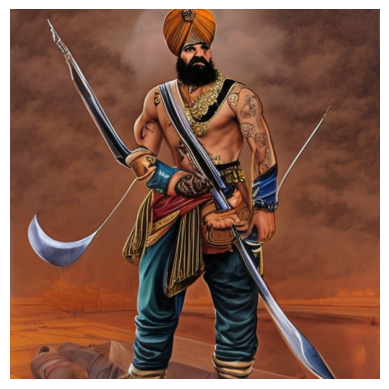

'/content/DeciDiffusionPipeline_a_Sikh,_Punjabi,_Jatt,_Nihang_warrior_vanquising_evil_across_the_world.full_body,_dynamic_pose,_intr.png'

In [ ]:
prompt = "a Sikh, Punjabi, Jatt, Nihang warrior vanquising evil across the world.full body, dynamic pose, intricate, highly detailed, digital painting, concept art, smooth, sharp focus, illustration, art by joe jusko"
text_to_image(deci_diffusion_pipeline, prompt)

<h1 style="font-size: 1000px;">⚖️ Compare Deci Diffusion to Stable Diffusion v1.5</h1>

In [ ]:
%%capture
stable_diffusion_pipeline = StableDiffusionPipeline.from_pretrained('runwayml/stable-diffusion-v1-5',
                                                                    torch_dtype=torch.float16)
stable_diffusion_pipeline = stable_diffusion_pipeline.to("cuda")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

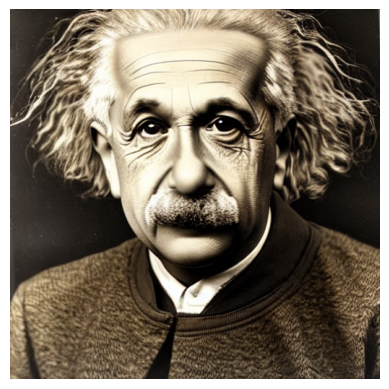

'/content/StableDiffusionPipeline_a_realistic_portrait_of_albert_einstein_with_a_bewildered_expression.png'

In [ ]:
text_to_image(stable_diffusion_pipeline, "a realistic portrait of albert einstein with a bewildered expression")

  0%|          | 0/50 [00:00<?, ?it/s]

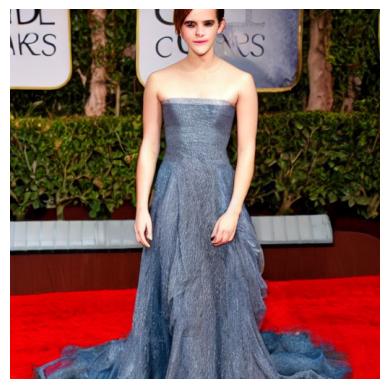

'/content/StableDiffusionPipeline_Emma_Watson_as_a_powerful_mysterious_sorceress,_casting_lightning_magic,_detailed_clothing.png'

In [ ]:
text_to_image(stable_diffusion_pipeline, "Emma Watson as a powerful mysterious sorceress, casting lightning magic, detailed clothing")

  0%|          | 0/50 [00:00<?, ?it/s]

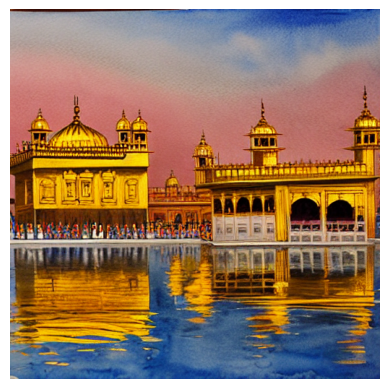

'/content/StableDiffusionPipeline_a_water_color_painting_of_the_Golden_Temple_awash_in_the_glow_of_morning_light_with_a_vanilla_sky.png'

In [ ]:
text_to_image(stable_diffusion_pipeline, "a water color painting of the Golden Temple awash in the glow of morning light with a vanilla sky")

  0%|          | 0/50 [00:00<?, ?it/s]

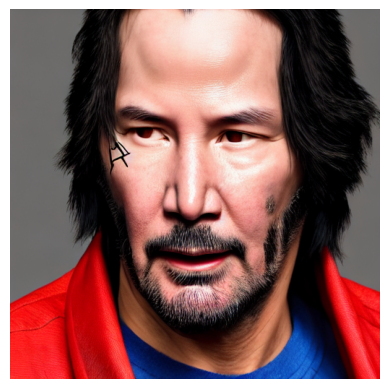

'/content/StableDiffusionPipeline_Keanu_Reeves_portrait_photo_of_a_asia_old_warrior_chief,_tribal_panther_make_up,_blue_on_red,_side_p.png'

In [ ]:
prompt = "Keanu Reeves portrait photo of a asia old warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes, 50mm portrait photography, hard rim lighting photography–beta –ar 2:3 –beta –upbeta –beta –upbeta –beta –upbeta"

text_to_image(stable_diffusion_pipeline, prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

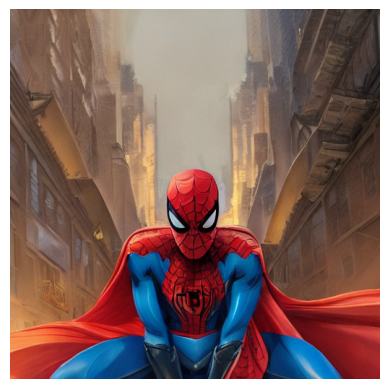

'/content/StableDiffusionPipeline_clear_portrait_of_a_superhero_concept_between_spiderman_and_batman,_cottagecore!!,_background_hyper_.png'

In [ ]:
prompt = "clear portrait of a superhero concept between spiderman and batman, cottagecore!!, background hyper detailed, character concept, full body, dynamic pose, intricate, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha"
text_to_image(stable_diffusion_pipeline, prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

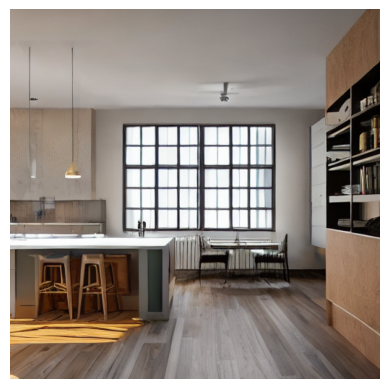

'/content/StableDiffusionPipeline_interior_design,_open_plan,_kitchen_and_living_room,_modular_furniture_with_cotton_textiles,_wooden_.png'

In [ ]:
prompt = "interior design, open plan, kitchen and living room, modular furniture with cotton textiles, wooden floor, high ceiling, large steel windows viewing a city"
text_to_image(stable_diffusion_pipeline, prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

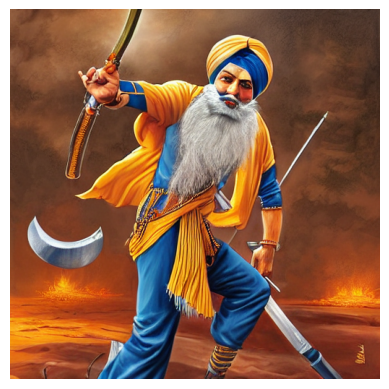

'/content/StableDiffusionPipeline_a_Sikh,_Punjabi,_Jatt,_Nihang_warrior_vanquising_evil_across_the_world.full_body,_dynamic_pose,_intr.png'

In [ ]:
prompt = "a Sikh, Punjabi, Jatt, Nihang warrior vanquising evil across the world.full body, dynamic pose, intricate, highly detailed, digital painting, concept art, smooth, sharp focus, illustration, art by joe jusko"
text_to_image(stable_diffusion_pipeline, prompt)